<span style="font-size:250%">Access the database</span>

This notebook is used for exploring, analyzing, and aggragating the GHTorrent Dataset.<br>
It primarily includes the queries with which I created my materialized views and some of the queries with which I explored the dataset.

For most of the queries, result sets and run times are attached as output of their cells. Note however, that for some longer running queries I was not able to hold the display sessions for the whole run time so only result sets are available.

From the work in this notebook, the small [dbUtils.py](./dbUtils.py) module was created, which provides a standardized way to run queries.<br>
Additionally, all resulting tables and view can be found in [this](docs/Data_Schema_DataExplorer.pdf) diagram.

The notebook is generally structured as follows: After an initial [overview of all project tables](#initial), [basic user language](#basis) information is collected. This information is used to select the [experiment users](#experiment_users). In the [appendix](#appendix), exploratory queries from the whole course of the project are collected.

---

In [1]:
import numpy as numpy
import matplotlib.pyplot as pyplot

In [2]:
%load_ext autoreload
%aimport dbUtils
%autoreload 1

<a class="anchor" id="initial"></a>

## Summary of all of project views and tables 

The following queries select all of the project tables and views (not only for this notebook). They can be identified by the prefix `lb_`. Relkind `r` denotes a table and `m` denotes a materialized view.<br>
This is meant as an overview to come back to.

In [139]:
dbUtils.runQuery('''    
    SELECT relid, schemaname, pg_stat_user_tables.relname, n_live_tup AS num_tuples, relkind
    FROM pg_stat_user_tables, pg_class
    WHERE schemaname = 'crm20'
    AND pg_stat_user_tables.relname::TEXT LIKE 'lb%%'
    AND relid = oid
''', mute=True)

Time used: 0.16159725189208984


,relid,schemaname,relname,num_tuples,relkind
0,1052413870,crm20,lb_sample_users,2754878,r
1,1052414557,crm20,lb_results1,532888,r
2,1052415013,crm20,lb_sample_projects,973407,m
3,1052415017,crm20,lb_sample_commits,14989050,m
4,1052415032,crm20,lb_changes,19094151,m
5,1052415055,crm20,lb_languages,2670733,m
6,1052415125,crm20,lb_polyglots,1545,r
7,1052415147,crm20,lb_controlgroup,1624,r
8,1052415245,crm20,lb_results2,9174,r
9,1052415263,crm20,lb_results3,5938896,r


Views:

In [140]:
dbUtils.runQuery('''
    SELECT table_schema AS schemaname, table_name AS relname, 'view' as relkind
    FROM INFORMATION_SCHEMA.views
    WHERE table_schema = 'crm20'
    AND table_name::TEXT LIKE 'lb%%'
''', mute=True)

Time used: 0.0829610824584961


,schemaname,relname,relkind
0,crm20,lb_java_users,view
1,crm20,lb_deltas,view
2,crm20,lb_controlgroupprojects,view
3,crm20,lb_polyglots_baseline,view
4,crm20,lb_experimentusers,view
5,crm20,lb_polyglotprojects,view
6,crm20,lb_authoravgs3,view


<a class="anchor" id="basis"></a> 

# Creating the basis for determining the users for my experiment

As the aim of this project is to analyze the code of special groups of developers, developer data needs to be aggregated. Especially language loc of developers is interesting.

## Table: Get sample users: 
The basis for all further aggregation is the `lb_sample_users` table. It contains a subset of all users in order to reduce the massive dataset that GHTorrent provides. Future work could abolish this limitation and run this project on all known users. Currently we just take 10 of 113 users, so approx. every 11th user. These are approx. 2.8M.

In [3]:
sampleUsers = dbUtils.runQuery('''
    DELETE FROM crm20.lb_sample_users;
    
    INSERT INTO crm20.lb_sample_users
        SELECT id 
        FROM ght.users 
        WHERE MOD(id, 113) = ANY('{1,2,3,5,8,13,21,34,55,89}')
        AND type = 'USR';
    
    SELECT * FROM crm20.lb_sample_users
''')
display(sampleUsers)

Time used: 31.120256185531616


,id
0,40898095
1,40898098
2,40898103
3,40898111
4,40898124
...,...
2754873,40898032
2754874,40898066
2754875,40898091
2754876,40898092


## View: Get projects the sample users worked on:
The `lb_sample_projects` materialized view is an intermediate view used to quickly determine the commits of the sample developers (which in turn are used to reflect on the coding activity of the developers). This detour is needed because of the massive size of the `ght.commits` table. Approx 973k entries.

In [4]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_sample_projects CASCADE;
    
    CREATE MATERIALIZED VIEW crm20.lb_sample_projects AS (
        SELECT DISTINCT repo_id
        FROM lb_sample_users, ght.project_members 
        WHERE id = user_id
    );
    
    SELECT * FROM crm20.lb_sample_projects
''')

Time used: 20.05700969696045


,repo_id
0,1
1,3
2,27
3,34
4,37
...,...
973402,137608196
973403,137608332
973404,137608999
973405,137609212


## View: Get Commits of Sample Users:

The materialized view `lb_sample_commits` includes all known commits that have been done by the sample users. These can later be used to reflect on the coding behavior of the user, as we can see which code a user wrote. Approx 15M entries.

In [9]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_sample_commits;
    
    CREATE MATERIALIZED VIEW crm20.lb_sample_commits AS (
        SELECT commits.id, sha, author_id, created_at, project_id 
        FROM crm20.lb_sample_projects, ght.commits, lb_sample_users
        WHERE repo_id = project_id
        AND author_id = lb_sample_users.id
    );
    
    SELECT * FROM crm20.lb_sample_commits
''')

Time used: 4282.222692966461


,id,sha,author_id,created_at,project_id
0,659298170,dfeaab04133a6a6673627aca05a226c72a456913,33618859,2017-03-31 10:09:59,60749223
1,660034020,0d0f26ccd423b850592ac243380bdb7dec8a8380,34104422,2017-04-01 11:43:16,59166975
2,660034029,301f441887b5a466cab17337502be81fabafa5d4,34104422,2017-04-01 11:43:51,59166975
3,660473226,08f03d40609d4e462802c4708ec1f3b1e1e65a65,34275391,2017-04-02 06:03:02,57899338
4,660473786,5db30f2999d9746245ca24cc3eec5d07de86e59c,34275391,2017-04-02 06:04:50,57899338
...,...,...,...,...,...
14989019,658761037,19bc50fe73e4b0c02a6783dcdf89e91415d89c50,1544938,2017-03-30 17:32:57,15785976
14989020,658843584,589305637a8c77decb2401394cd0949f9bc72bcb,1544938,2017-03-30 17:08:17,15785976
14989021,658843597,794e0b908e2de2d833f7c83467209d5ff8a4db83,1544938,2017-03-30 19:31:17,15785976
14989022,658920360,85901f6275239b677047e285b2670bddde4d0756,54920,2017-02-23 16:51:12,15754


## Question: How does ght.raw_patches count deletions and changes?

The `ght.raw_patches` provides information about commit changes (and therefore languages). <br>
However, I need to know how the table calculates its numbers for changed loc. This was especially important in the first big iteration, as at that time I used this information to calculate commit sizes for the metrics. However, the data is still used to determine how many loc in which language a developer has approximately written.

For starters I took a random commit from https://github.com/italiangrid/voms-admin-server (which is a repo I can still access on github to cross reference what how the numbers are calculated)

In [131]:
dbUtils.runQuery('''
    SELECT *
    FROM ght.raw_patches
    WHERE sha = '95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
    LIMIT 20
''', True)

,sha,name,previous_filename,changes,deletions,status,patch
0,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,29,13,modified,"@@ -17,12 +17,16 @@\n \n import java.util.List..."
1,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,43,7,modified,"@@ -24,8 +24,11 @@\n import org.hibernate.Crit..."
2,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,33,0,added,"@@ -0,0 +1,33 @@\n+/**\n+ * Copyright (c) Isti..."
3,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,17,4,modified,"@@ -21,6 +21,7 @@\n import org.glite.security...."
4,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,7,1,modified,"@@ -99,10 +99,13 @@ public void checkOrgDBConn..."
5,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,46,34,modified,"@@ -63,41 +63,14 @@ protected void synchronize..."
6,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/jq...,,16617,0,added,
7,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/jq...,,1225,0,added,"@@ -0,0 +1,1225 @@\n+/*! jQuery UI - v1.11.4 -..."
8,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/im...,,0,0,added,
9,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/im...,,0,0,added,


To find the repository online: What is it's project id?

In [129]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.commits
    WHERE sha='95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
''', True)

,id,sha,author_id,committer_id,project_id,created_at
0,650784538,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,119958,30351173,1586836,2017-03-23 19:55:24


What is the url for this project id?

In [130]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.projects
    WHERE id='1586836'
''', True)['url'][0]

'https://api.github.com/repos/italiangrid/voms-admin-server'

See https://github.com/italiangrid/voms-admin-server/commit/95b5c803ccfc8ae3c015a4681ec14f5b2579896a: 

By looking the commit up online I found out the following:<br>
* For Docker-compose: Changes = Additions + Deletions, but: Changed lines have additions and deletes so count "twice"
* configure-vo.sh was completely deleted, so changes = deletions

I also tried out the idea to derive all analysis infos directly from the attached patches in the table, but later discarded this idea. However, it basically works to extract changed lines using psql regex.

In [246]:
dbUtils.runQuery('''
    SELECT name, patch, (SELECT COUNT(*) FROM REGEXP_MATCHES(patch, '^\+', 'gn')) as occ
    FROM ght.raw_patches
    WHERE sha = '95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
    LIMIT 20
''', True)

,name,patch,occ
0,voms-admin-server/src/main/java/org/glite/secu...,"@@ -17,12 +17,16 @@\n \n import java.util.List...",16
1,voms-admin-server/src/main/java/org/glite/secu...,"@@ -24,8 +24,11 @@\n import org.hibernate.Crit...",36
2,voms-admin-server/src/main/java/org/glite/secu...,"@@ -0,0 +1,33 @@\n+/**\n+ * Copyright (c) Isti...",33
3,voms-admin-server/src/main/java/org/glite/secu...,"@@ -21,6 +21,7 @@\n import org.glite.security....",13
4,voms-admin-server/src/main/java/org/glite/secu...,"@@ -99,10 +99,13 @@ public void checkOrgDBConn...",6
5,voms-admin-server/src/main/java/org/glite/secu...,"@@ -63,41 +63,14 @@ protected void synchronize...",12
6,voms-admin-server/src/main/webapp/jquery-ui/jq...,,0
7,voms-admin-server/src/main/webapp/jquery-ui/jq...,"@@ -0,0 +1,1225 @@\n+/*! jQuery UI - v1.11.4 -...",1225
8,voms-admin-server/src/main/webapp/jquery-ui/im...,,0
9,voms-admin-server/src/main/webapp/jquery-ui/im...,,0


## View: Commit Data with changed languages (file endings) and loc

The `lb_changes` materialized view aggregates the data from `raw_patches`. It collects for each commit the changed loc for each file ending. Approx. 19M tuples<br>
(Note: For the analyzed languages, file ending maps to language, which is why the column is called 'language'. Of course for languages like C where there are .c and .h this does not 100% map)

The original query seemed to run too long after the last up-scale. I therefore tried to decrease the dataset with some pre-filtering of file endings that I knew from previous iterations that they are common but not relevant for our analysis (mostly images, configurations and html/css).

In [26]:
with dbUtils.engine.connect() as con:
    plan = con.execute('''
            EXPLAIN
                WITH patches_with_languages AS (
                    SELECT *, SUBSTRING(name from '\.([^\.]*)$') AS language
                    FROM ght.raw_patches
                )
                SELECT id AS commit_id, lb_sample_commits.sha, SUM(changes-deletions) AS loc, language
                FROM crm20.lb_sample_commits, patches_with_languages
                WHERE lb_sample_commits.sha = patches_with_languages.sha
                AND language <> ALL('{"png", "md", "None", "txt", "gitignore", "html", "css", "scss", "xml", "json", "jpg", "yml", "svg", "ttf", "properties", "gif", "ico", "lock", "pdf"}')
                GROUP BY commit_id, lb_sample_commits.sha, language
        ''')
    for row in plan:
        print(row)

('Finalize GroupAggregate  (cost=1228276773.24..2894963439.52 rows=11052748493 width=85)',)
('  Group Key: lb_sample_commits.id, lb_sample_commits.sha, ("substring"(raw_patches.name, \'\\.([^\\.]*)$\'::text))',)
('  ->  Gather Merge  (cost=1228276773.24..2646276598.48 rows=11052748488 width=85)',)
('        Workers Planned: 12',)
('        ->  Partial GroupAggregate  (cost=1228275773.00..1253604988.28 rows=921062374 width=85)',)
('              Group Key: lb_sample_commits.id, lb_sample_commits.sha, ("substring"(raw_patches.name, \'\\.([^\\.]*)$\'::text))',)
('              ->  Sort  (cost=1228275773.00..1230578428.93 rows=921062374 width=85)',)
('                    Sort Key: lb_sample_commits.id, lb_sample_commits.sha, ("substring"(raw_patches.name, \'\\.([^\\.]*)$\'::text))',)
('                    ->  Parallel Hash Join  (cost=278848.72..914838363.65 rows=921062374 width=85)',)
('                          Hash Cond: (raw_patches.sha = (lb_sample_commits.sha)::bpchar)',)
('         

In [ ]:
dbUtils.log('Start running lb_changes creation query')
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_changes CASCADE;
    
    CREATE MATERIALIZED VIEW crm20.lb_changes AS (
        WITH patches_with_languages AS (
            SELECT *, SUBSTRING(name from '\.([^\.]*)$') AS language
            FROM ght.raw_patches
        )
        SELECT id AS commit_id, lb_sample_commits.sha, SUM(changes-deletions) AS loc, language
        FROM crm20.lb_sample_commits, patches_with_languages
        WHERE lb_sample_commits.sha = patches_with_languages.sha
        AND language <> ALL('{"png", "md", "None", "txt", "gitignore", "html", "css", "scss", "xml", "json", "jpg", "yml", "svg", "ttf", "properties", "gif", "ico", "lock", "pdf"}')
        GROUP BY commit_id, lb_sample_commits.sha, language
    );
    
    SELECT * FROM crm20.lb_changes
''')
dbUtils.log('End running lb_changes creation query')

`
========= 2020-08-08 12:57:34.273556 ==========
Start running lb_changes creation query
========= 2020-08-10 11:21:37.708049 ==========
End running lb_changes creation query
`

So the run time was approximately 1d 22h

In [5]:
dbUtils.runQuery('''SELECT * FROM crm20.lb_changes''')

Time used: 57.23912739753723


,commit_id,sha,loc,language
0,1,019d0e7872c67fdc6996488e2aa6b64a03c87b9b,2,rb
1,2,397238b49c88d1d8e6c1efb94a51e9d0cdb16475,3,rdoc
2,3,55bf5367875ec9e81a0ab62cfffb66f4335a064e,2,haml
3,3,55bf5367875ec9e81a0ab62cfffb66f4335a064e,58,rb
4,4,9d653ea84c6df1b903a354dfcf0f4720359498d8,6,gemspec
...,...,...,...,...
19094152,1415397444,928c7881428dbd748356c81958391ca8ebd7db93,9,sh
19094153,1415397445,09038b794929509bd61b633af3403c2d4510327f,15,rb
19094154,1415397445,09038b794929509bd61b633af3403c2d4510327f,1,sh
19094155,1415397446,7f7aeafd06f98dcee427cb1d1757d9ce90565ed2,6,rb


### Question: How many sample commits are there, where we do not have patch data to?

As a validation to see if we can reflect on the sample commits on the basis of the `raw_patches` table, let's query of how many of the sample commits we have language data.<br>
Note: Because of the optimization done in the last scaling (that filters some file endings out), the result went down as expected. However, previous runs have shown values like 80%

Result: 4M of  15M. This is not much, however, we know that the values have been pre-filtered.

In [11]:
dbUtils.runQuery('''
    SELECT lb_sample_commits.id
    FROM crm20.lb_sample_commits
    LEFT JOIN crm20.lb_changes
    ON lb_sample_commits.id = lb_changes.commit_id
    GROUP BY lb_sample_commits.id
    HAVING COUNT(lb_changes.language) = 0
''')

Time used: 30.1655490398407


,id
0,5
1,9
2,10
3,12
4,18
...,...
4154835,1415397117
4154836,1415397209
4154837,1415397435
4154838,1415397438


## View: Which author did which languages (file endings)?

The `lb_languages` view includes the language information about authors that we use to determine which of them count as java developers and then which of thos should be used as polyglot group or control group. This includes the lines of code each dev wrote in each language (still identified by file ending) as well as the dates when the developer started and stopped to write the language (to argue about developer lifecycle). Approx 2.7M tuples.

In [9]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_languages CASCADE;
    
    CREATE MATERIALIZED VIEW crm20.lb_languages AS (
        SELECT author_id, language, SUM(loc) AS loc, MIN(created_at) as first_written, MAX(created_at) as last_written
        FROM crm20.lb_sample_commits, crm20.lb_changes
        WHERE lb_sample_commits.id = lb_changes.commit_id
        GROUP BY author_id, language
    );
        
    SELECT * FROM crm20.lb_languages
''')

Time used: 22.305572032928467


,author_id,language,loc,first_written,last_written
0,1,gemspec,20.0,2010-09-06 14:12:14,2012-08-01 20:51:52
1,1,haml,5.0,2011-04-14 07:02:08,2011-04-14 07:02:08
2,1,rb,65.0,2010-03-02 10:36:44,2016-12-21 14:06:30
3,1,rdoc,18.0,2011-03-03 07:45:43,2011-03-03 07:45:43
4,2,applescript,20.0,2018-06-07 07:38:52,2018-06-28 02:48:31
...,...,...,...,...,...
2670728,51687896,pro,21.0,2019-05-31 19:04:49,2019-05-31 19:04:49
2670729,51688581,java,241.0,2019-05-29 18:00:44,2019-05-30 16:23:02
2670730,51688581,js,319.0,2019-05-29 16:01:55,2019-05-30 16:23:02
2670731,51691566,sql,360.0,2019-05-31 17:55:27,2019-05-31 17:55:27


### Question: How many developers in which languages do we have?
To select the right secondary languages for the experiments, this query shows the distribution of developers over languages (file endings). Developers that just have deleted code are not counted in.<br>
Note: The file endings have already been pre-filtered for files such as images, documents or web pages

Result: The query shows that the most popular language is Javascript, followed by Java, Python, PHP, the C-language family and Ruby.

In [43]:
dbUtils.runQuery('''
    SELECT language, COUNT(author_id) AS devs
    FROM crm20.lb_languages
    WHERE loc > 0
    GROUP BY language
    ORDER BY devs DESC
    LIMIT 30
''')

Time used: 0.6021225452423096


,language,devs
0,js,100762
1,java,69072
2,py,47411
3,php,33502
4,h,29367
5,sh,25158
6,cs,24617
7,cpp,20759
8,rb,19852
9,map,19203


<a class="anchor" id="experiment_users"></a>

# Select Experiment Users

After we now know which author did which language, we can start to select our experiment groups. The first step is to determine java developers.

## Question: How many Java users have written more than X thousand Java lines?

First, let's find out how many Java developers there are that have more than a given limit of lines of code.<br>
The following chart already includes markings for a limit of 3k and an expected number of developers of 15k. In previous runs, these numbers have proven to to provide reasonable results. However, this might a point that can be adapted (e.g. setting the limit higher and having less, but more experienced subjects or setting it lower and having it the other way round.

The resulting chart shows that developers with more than x k Java LoC are distributed in a hyperbolic fashion. It gives us the information of how many developers we would retain if we filtered for certain amounts of Java lines of code.

This version of this graph, and older ones, can be found in [./results/](./results/)  

Time used: 0.38004159927368164


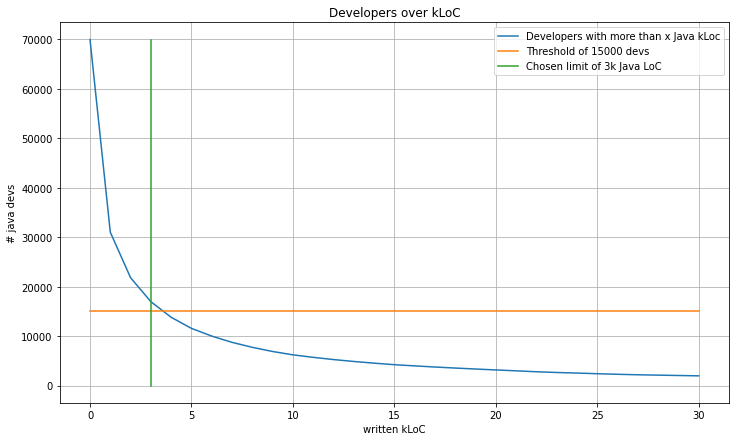

In [30]:
x = []
y = []
threshold = 15000
limit = 3
result = dbUtils.runQuery('''
    SELECT index, COUNT(author_id) AS num
    FROM 
        crm20.lb_languages,
        (SELECT GENERATE_SERIES(0,30) AS index) AS indexes
    WHERE language = 'java' AND loc >= index * 1000
    GROUP BY index
    ORDER BY index
''', True)
pyplot.figure(figsize=(12, 7))
pyplot.grid()
pyplot.title('Developers over kLoC')
pyplot.xlabel('written kLoC')
pyplot.ylabel('# java devs')
pyplot.plot(result['index'], result['num'])
pyplot.plot([0, len(result['num'])-1], [threshold, threshold])
pyplot.plot([limit, limit], [0, result['num'][0]])
pyplot.legend(['Developers with more than x Java kLoc', 'Threshold of '+str(threshold)+' devs', 'Chosen limit of 3k Java LoC'])
pyplot.savefig('results/current/javaDevPerLoc.png')

## View: Java Users

The view `lb_java_users` includes all users that are deemed Java developers for the purposes of this project. They are selected by a simple filter over their written java loc, taking 3k as (adaptable) threshold. Approx. 17k tuples.

In [36]:
dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_java_users;
    
    CREATE VIEW crm20.lb_java_users AS (
        SELECT *
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc > 3000
    );
    
    SELECT * FROM crm20.lb_java_users
''')

Time used: 0.24182987213134766


,author_id,language,loc,first_written,last_written
0,118,java,4458.0,2014-07-12 13:58:27,2016-10-01 16:22:09
1,234,java,14820.0,2010-10-02 03:45:10,2017-04-12 03:42:47
2,454,java,862734.0,2007-04-04 04:13:59,2019-02-19 13:22:17
3,573,java,100198.0,2012-08-23 15:11:38,2014-10-14 18:47:33
4,767,java,3087.0,2017-10-19 00:31:22,2018-07-12 13:57:04
...,...,...,...,...,...
16939,51568262,java,3544.0,2019-05-30 12:46:10,2019-05-30 15:15:16
16940,51552421,java,4481.0,2019-05-25 04:43:20,2019-05-30 11:24:10
16941,51521562,java,3752.0,2019-05-23 16:46:05,2019-05-30 12:44:35
16942,51593658,java,7122.0,2019-05-27 12:59:14,2019-05-31 13:34:42


### Question: What secondary languages do these java developers have?

To select the right secondary languages for our polyglot group, let's explore how many Java devs have a certain secondary language.

Result: Apart from the additional java-specific file endings (such as classpath, project, gradle), JavaScript is quite common (44%) and Python can be found (16%). Other common languages, notably Ruby (5%) are less common.

In [46]:
dbUtils.runQuery('''
    SELECT language, COUNT(author_id) AS devs
    FROM crm20.lb_languages
    WHERE loc > 0
    AND author_id IN (SELECT author_id FROM crm20.lb_java_users)
    GROUP BY language
    ORDER BY devs DESC
    LIMIT 50
''')

Time used: 0.7575607299804688


,language,devs
0,java,16944
1,js,7594
2,classpath,6161
3,project,5767
4,gradle,4971
5,prefs,4927
6,iml,3948
7,bat,3636
8,sql,3307
9,sh,2927


## Table: Polyglot Users

The `lb_polyglots` table includes all users that are deemed polyglots for the purposes of this project. Polyglots are the java developers that learned another language after Java. We analyze the code of this group in comparison to the control group which consists of those java developers who did not write another language. Because this data is the "result" of this notebook, it is put into a table.

As languages for polyglots, Javascript and Python are chosen as most common. Developers are filtered among further criteria: To ensure that they really "learned" the new language, 1kloc in the secondary language is expected. To ensure that java is the first language, they must have started writing java before writing the second language. Lastly, to ensure that they are still comparable to the control group, the java loc are expected to be more than the secondary lines of code. (Historically, secondary lines of code needed to come below half of the java loc, but this has been abolished in the last run. All factors can be adapted in further simulation runs to see if the results change. 

### Baseline table

To explore the results of this filtering, the `lb_polyglots_baseline` view has been created: This view only includes the more than 1kloc clause.
This results in much more tuples (5.5k)


In [57]:
dbUtils.runQuery('''
        DROP VIEW IF EXISTS crm20.lb_polyglots_baseline;
        
        CREATE VIEW crm20.lb_polyglots_baseline AS (
            SELECT 
                lb_java_users.author_id, lb_java_users.loc AS java_loc, lb_java_users.first_written as java_start, lb_java_users.last_written as java_end,
                ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS sec_loc, ARRAY_AGG(lb_languages.first_written) as sec_start, ARRAY_AGG(lb_languages.last_written) as sec_end
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc, lb_java_users.first_written, lb_java_users.last_written
        );
        
        SELECT * FROM crm20.lb_polyglots_baseline
''')

Time used: 0.5506625175476074


,author_id,java_loc,java_start,java_end,secondary_languages,sec_loc,sec_start,sec_end
0,118,4458.0,2014-07-12 13:58:27,2016-10-01 16:22:09,"[js, py]","[1704, 8903]","[2012-03-22 16:26:40, 2011-08-10 13:55:19]","[2014-08-10 14:37:14, 2018-05-27 08:46:04]"
1,234,14820.0,2010-10-02 03:45:10,2017-04-12 03:42:47,"[js, py]","[94188, 167502]","[2013-10-22 01:44:42, 2012-01-19 22:26:25]","[2018-06-28 05:21:54, 2014-07-10 16:55:14]"
2,454,862734.0,2007-04-04 04:13:59,2019-02-19 13:22:17,"[js, py]","[560540, 1030589]","[2012-08-14 06:46:50, 2012-08-11 06:37:04]","[2019-02-19 13:22:17, 2019-05-26 15:36:03]"
3,573,100198.0,2012-08-23 15:11:38,2014-10-14 18:47:33,[js],[6312],[2012-08-07 19:05:58],[2014-05-02 16:26:56]
4,792,68881.0,2011-12-28 19:07:05,2013-08-30 10:37:26,"[js, py]","[51725, 20042]","[2012-01-20 20:43:01, 2011-02-19 04:43:27]","[2014-10-19 12:36:21, 2019-05-15 21:10:27]"
...,...,...,...,...,...,...,...,...
5562,51115666,4127.0,2009-05-08 18:30:54,2009-06-30 19:31:07,[py],[7083],[2009-05-08 18:30:54],[2009-07-09 15:58:37]
5563,51242470,18872.0,2019-05-13 06:09:36,2019-05-13 06:09:36,[py],[76788],[2019-05-09 22:14:30],[2019-05-29 03:53:46]
5564,51284619,3106.0,2019-05-14 09:12:21,2019-05-27 01:32:25,[js],[3416],[2019-05-14 06:40:23],[2019-05-31 07:10:59]
5565,51321696,3169.0,2019-05-16 14:30:45,2019-05-24 05:23:41,[js],[37057],[2019-05-16 14:54:56],[2019-05-22 13:27:26]


### Actual table

As described above; approx. 1.5k Tuples

In [58]:
dbUtils.runQuery('''
        DROP TABLE IF EXISTS crm20.lb_polyglots;
        
        CREATE TABLE crm20.lb_polyglots AS (
            SELECT * FROM crm20.lb_polyglots_baseline
            WHERE java_loc > ALL(sec_loc)
            AND java_start < ALL(sec_start)
        );
        
        SELECT * FROM crm20.lb_polyglots
''')

Time used: 0.40510988235473633


,author_id,java_loc,java_start,java_end,secondary_languages,sec_loc,sec_start,sec_end
0,1185,46950.0,2011-05-28 14:02:22,2018-11-15 14:43:39,[js],[3356],[2013-06-20 13:27:25],[2018-04-18 09:50:28]
1,3253,57532.0,2012-08-02 14:59:21,2019-04-01 13:08:38,[py],[29757],[2013-04-18 12:05:03],[2019-03-26 17:16:37]
2,3506,19523.0,2017-05-04 22:58:08,2018-08-28 19:30:29,[py],[12176],[2017-05-16 21:48:17],[2018-09-20 13:53:41]
3,5655,3107.0,2012-07-15 22:32:06,2017-09-19 20:08:39,[js],[2756],[2012-09-23 00:30:51],[2016-01-08 23:29:43]
4,5877,14842.0,2012-01-11 22:03:43,2013-09-14 14:04:22,[js],[2818],[2012-08-09 22:24:42],[2014-10-03 17:55:12]
...,...,...,...,...,...,...,...,...
1540,49700001,36219.0,2019-04-02 08:11:48,2019-05-28 12:35:23,[js],[2873],[2019-04-07 08:26:30],[2019-05-30 02:22:24]
1541,50301387,9919.0,2019-04-14 07:33:50,2019-04-26 21:37:13,[js],[2197],[2019-04-15 13:08:06],[2019-04-27 01:29:13]
1542,50866952,8143.0,2019-04-24 12:10:09,2019-05-24 08:33:58,[js],[2925],[2019-05-17 10:16:06],[2019-05-17 10:16:06]
1543,50930803,6274.0,2019-04-26 10:25:47,2019-05-27 12:23:54,[js],[4216],[2019-04-26 11:43:12],[2019-05-21 03:18:43]


### Question: How many baseline polyglots have which combination of experiment secondary languages?

Out of curiosity: How are the secondary languages that are going to be chosen for the experiment distributed among all Java developers?

There are mostly Javascript-only secondaries, which ist sad because the python influence will be smaller

In [59]:
dbUtils.runQuery('''
    SELECT secondary_languages, COUNT(author_id)
    FROM crm20.lb_polyglots_baseline
    GROUP BY secondary_languages
''')

Time used: 0.3791477680206299


,secondary_languages,count
0,[js],4554
1,"[js, py]",312
2,[py],519
3,"[py, js]",182


### Question: How many polyglots have which combination of experiment secondary languages?

As comparison to the above question

Result: The proportion of Python developers has increased, which is generally nice but can imply that the polyglot set is not representative enough.

In [56]:
dbUtils.runQuery('''
    SELECT secondary_languages, COUNT(author_id)
    FROM crm20.lb_polyglots
    GROUP BY secondary_languages
''')

Time used: 0.0029010772705078125


,secondary_languages,count
0,"[js, py]",54
1,[py],263
2,"[py, js]",23
3,[js],1205


### Question: How many baseline polyglots have started all their "secondary" language before Java?

So how many people are filtered out by this criterium? Approx. 1.6k

In [65]:
dbUtils.runQuery('''
    SELECT secondary_languages, COUNT(author_id)
    FROM crm20.lb_polyglots_baseline
    WHERE java_start > ANY(sec_start)
    GROUP BY secondary_languages
''')

Time used: 0.3850283622741699


,secondary_languages,count
0,[js],1184
1,"[js, py]",176
2,[py],171
3,"[py, js]",91


### Question: How many baseline polyglots write n times as much Java code as their secondary language?

Historically, polyglots were filtered by a factor that java loc needed to be greater thatn the secondary locs.<br>
The following chart shows how many of the developers we retain for different factors. The currently chosen factor is 1 which already decreases the set but makes the polyglots more comparable to the control group.

This version of this graph, and older ones, can be found in [./results/](./results/)  

Time used: 2.268939971923828
Time used: 1.446249008178711


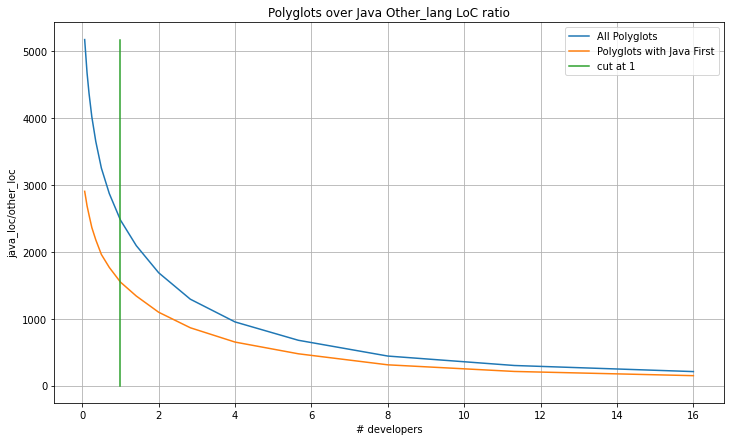

In [89]:
x = []
y = []
result = dbUtils.runQuery('''
    SELECT POWER(2, exponent) AS factor, COUNT(author_id) AS devs 
    FROM crm20.lb_polyglots_baseline, (SELECT GENERATE_SERIES(-4,4,0.5) AS exponent) AS factors
    WHERE java_loc / POWER(2, exponent) >= ALL(sec_loc)
    GROUP BY factor
    ORDER BY factor
''', True)
x = result['factor']
y = result['devs']
    

x2 = []
y2 = []
result = dbUtils.runQuery('''
    SELECT POWER(2, exponent) AS factor, COUNT(author_id) AS devs 
    FROM crm20.lb_polyglots_baseline, (SELECT GENERATE_SERIES(-4,4,0.5) AS exponent) AS factors
    WHERE java_loc / POWER(2, exponent) >= ALL(sec_loc)
    AND java_start < ALL(sec_start)
    GROUP BY factor
    ORDER BY factor
''', True)
x2 = result['factor']
y2 = result['devs']
    
cut = 1
pyplot.figure(figsize=(12, 7))
pyplot.grid()
pyplot.title('Polyglots over Java Other_lang LoC ratio')
pyplot.xlabel('# developers')
pyplot.ylabel('java_loc/other_loc')
pyplot.plot(x, y)
pyplot.plot(x2, y2)
pyplot.plot([cut, cut], [0,y[0]])
pyplot.legend(['All Polyglots', 'Polyglots with Java First', 'cut at '+str(cut)])
pyplot.savefig('results/current/polyglotsPerFactor.png')

## Table: Control group users

The table `lb_controlgroup` includes all users that are selected for the control group of this project. This means these are the developers that we compare our polyglots to in order to determine if there is an influence of learning a new language.

The control group consists of java developers that have not learned Python or Javascript (as opposed to the polyglot group). They are filtered to have more java loc (4k) to make up for the foreign language loc that polyglots have. They are further filtered to one quarted to ensure that both experiment groups are approximately the same size.

In [94]:
dbUtils.runQuery('''
        DROP TABLE IF EXISTS crm20.lb_controlgroup;
        
        CREATE TABLE crm20.lb_controlgroup AS (
            SELECT lb_java_users.author_id, lb_java_users.loc AS java_loc, lb_java_users.first_written as java_start, lb_java_users.last_written as java_end
            FROM crm20.lb_java_users
            WHERE author_id NOT IN (SELECT author_id FROM crm20.lb_languages WHERE (language = 'py' OR language = 'js'))
            AND MOD(author_id, 4) = 3 
            AND loc > 4000
        );
        
        SELECT * FROM crm20.lb_controlgroup
''')

Time used: 23.63264298439026


,author_id,java_loc,java_start,java_end
0,10451,19516.0,2011-04-03 22:54:50,2016-03-17 04:40:02
1,16503,98800.0,2010-09-30 11:48:03,2012-01-23 21:03:58
2,29043,14434.0,2012-06-12 00:54:09,2014-05-30 14:23:28
3,29695,8497.0,2014-10-28 23:59:22,2015-07-30 16:09:17
4,30983,23544.0,2013-02-11 18:33:46,2013-05-09 04:32:40
...,...,...,...,...
1619,50928511,6227.0,2019-04-25 22:21:45,2019-05-26 14:56:02
1620,51283695,5198.0,2019-05-10 08:49:30,2019-05-24 03:43:56
1621,51415599,5774.0,2019-05-19 03:37:40,2019-05-19 03:37:40
1622,51485175,15412.0,2019-05-23 11:42:37,2019-05-28 23:51:22


## Utility views

The following views are used for utility. 

`lb_polyglotProjects` and `lb_controlgroupProjects` include the subset of projects, that the polyglot and control group developers were involved. This information is used in other notebooks to determine which repositories to download.

`lb_experimentusers` is the union of both groups.

In [95]:
polyglotProjects = dbUtils.runQuery('''
    CREATE VIEW crm20.lb_polyglotProjects AS (
        SELECT DISTINCT repo_id, url, name
        FROM lb_polyglots, ght.project_members, ght.projects
        WHERE author_id = user_id
        AND repo_id = id
    );
    SELECT * FROM  crm20.lb_polyglotProjects
''')
display(polyglotProjects)
controlgroupProjects = dbUtils.runQuery('''
    CREATE VIEW crm20.lb_controlgroupProjects AS (
        SELECT DISTINCT repo_id, url, name
        FROM lb_controlgroup, ght.project_members, ght.projects
        WHERE author_id = user_id
        AND repo_id = id
    );
    SELECT * FROM crm20.lb_controlgroupProjects
''')
display(controlgroupProjects)

Time used: 13.691898107528687


,repo_id,url,name
0,613,https://api.github.com/repos/MovingBlocks/Tera...,Terasology
1,708,https://api.github.com/repos/twitter/bootstrap,bootstrap
2,807,https://api.github.com/repos/openmicroscopy/bi...,bioformats
3,1007,https://api.github.com/repos/Mojang/Minecraft-API,Minecraft-API
4,1041,https://api.github.com/repos/openzipkin/zipkin,zipkin
...,...,...,...
11855,136582999,https://api.github.com/repos/gabcarrara/Estrut...,Estrutura-de-Dados-Pos
11856,136621277,https://api.github.com/repos/ninaangelvik/puse...,pusefinn-unity
11857,136670672,https://api.github.com/repos/jualinfer/ISPP,ISPP
11858,136724786,https://api.github.com/repos/ramesesinc/module...,modules-partner


Time used: 4.369609594345093


,repo_id,url,name
0,605,https://api.github.com/repos/aerogear/aerogear-js,aerogear-js
1,613,https://api.github.com/repos/MovingBlocks/Tera...,Terasology
2,4751,https://api.github.com/repos/Catrobat/Catroid,Catroid
3,5444,https://api.github.com/repos/apigee/usergrid-s...,usergrid-stack
4,5945,https://api.github.com/repos/cytoscape/cytosca...,cytoscape.js
...,...,...,...
4827,136244537,https://api.github.com/repos/ls1390682742/WanA...,WanAndroid
4828,136483020,https://api.github.com/repos/scogin/MiniProjec...,MiniProject_Cafe
4829,136555507,https://api.github.com/repos/BrunoML1991/userM...,userMicroserviceTFM
4830,136650181,https://api.github.com/repos/qtumproject/pi-gen,pi-gen


In [96]:
dbUtils.runQuery('''
    CREATE VIEW crm20.lb_experimentusers AS (
        SELECT author_id
        FROM crm20.lb_polyglots 
        UNION
        SELECT author_id
        FROM crm20.lb_controlgroup
    );
    SELECT * FROM  crm20.lb_experimentusers
''')

Time used: 0.018419265747070312


,author_id
0,30627747
1,44599187
2,42349131
3,3533565
4,1347191
...,...
3164,10441434
3165,48349775
3166,6495581
3167,4540795


--- 
<a class="anchor" id="appendix"></a>

# Appendix
The appendix includes queries that I used in parallel to the project to explore the available.

## Exploring basic GHTorrent Tables
In the beginning, I tried to explore which data is available and how it is composed

* 1.368.235.072 Commits
*    32.411.734 Users
*   125.486.232 Projects

### Commits

In [4]:
dbUtils.runQuery('''
    SELECT COUNT(*) FROM ght.commits
''')

Time used: 2832.7056472301483


,count
0,1368235072


In [7]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.commits
    LIMIT 10
''')

Time used: 0.7459335327148438


,id,sha,author_id,committer_id,project_id,created_at
0,659097136,71c562ee7229025a7b0100f2f6777ddd38787e46,34908882,34908882,60593534,2017-03-31 03:23:47
1,659097137,602eeca0f6cf3c757632466a31d2767572cf3107,30554679,30351173,58045027,2017-03-31 03:23:57
2,659097138,346c39b02dcf1a5036c133d042e1ecc479fa7776,4752971,4752971,60810981,2017-03-31 03:23:56
3,659097139,0c2721961165a87a16b8d21dcffc803945bdc39e,34002213,34002213,56875827,2017-03-31 03:23:30
4,659097140,0bd4336b30c35ada38e620f103edaadd72a5a86b,780889,780889,19453540,2017-03-31 03:23:56
5,659097141,93beb5abb9f2699cda3a68b422621dcf64759497,32094706,32094706,60236433,2017-03-31 03:23:58
6,659097142,f2c7176cbaf54fcffe473a3b95e78146098dac4d,7040125,7040125,59349380,2017-03-31 03:22:07
7,659097143,20fccf688358c14db512f16d1ff6c947c6ee402c,11249739,11249739,38434455,2017-03-31 03:23:33
8,659097144,8158f6bfb4958abdc145ca420fa3712622d40f40,10550932,10550932,52984520,2017-03-31 03:23:46
9,659097145,fa45b10200be9f6cc0a008dce17b145c6dbb6ec3,7198145,30351173,55832557,2017-03-31 03:24:01


In [2]:
dbUtils.runQuery('''
    SELECT column_name, data_type 
    FROM information_schema.columns
    WHERE table_name = 'commits';
''')

Time used: 0.3947935104370117


,column_name,data_type
0,id,integer
1,author_id,integer
2,committer_id,integer
3,project_id,integer
4,created_at,timestamp without time zone
5,sha,character varying


### Users

In [5]:
dbUtils.runQuery('''
    SELECT * FROM ght.users
''')

Time used: 674.6072964668274


,id,login,company,created_at,type,fake,deleted,long,lat,country_code,state,city,location
0,40898094,allydunham,None,2017-07-24 17:04:33,USR,False,False,0.000000,0.000000,None,None,None,None
1,40898095,Hamzehsh2,None,2018-01-26 10:38:47,USR,False,False,0.000000,0.000000,None,None,None,None
2,40898096,tkzjustin,Eternal Dragonz,2017-01-21 03:36:04,USR,False,False,151.203003,-33.874001,au,NSW,Sydney,"Sydney, AU"
3,40898097,zimj,#currentlyastudent,2017-06-18 09:48:36,USR,False,False,72.830093,18.930130,in,Maharashtra,Mumbai,Mumbai
4,40898098,NHAUROSH,None,2018-01-26 10:45:42,USR,True,False,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32411729,40898090,EWPYLDIP,None,2018-01-26 10:45:12,USR,True,False,NaN,NaN,None,None,None,None
32411730,40898091,TCPPCJXA,None,2018-01-26 10:45:13,USR,True,False,NaN,NaN,None,None,None,None
32411731,40898092,WilonaDU,None,2018-01-26 02:59:47,USR,False,False,0.000000,0.000000,None,None,None,None
32411732,40898093,ttrgrchck,None,2018-01-26 10:42:56,USR,False,False,0.000000,0.000000,None,None,None,None


### Projects 

In [7]:
dbUtils.runQuery('''
    SELECT * FROM ght.projects
''')

Time used: 2348.3794589042664


,id,url,owner_id,name,description,language,created_at,forked_from,deleted,updated_at,forked_commit_id
0,11689147,https://api.github.com/repos/robot9706/Minecra...,2852592,MinecraftModelExporter,A simple tool for converting Minecraft worlds ...,C#,2014-08-26 17:16:07,NaN,False,2016-03-03 00:03:18,NaN
1,11689151,https://api.github.com/repos/Gruuler/pinteresting,4856900,pinteresting,,Ruby,2014-08-25 21:26:22,NaN,False,2016-02-18 03:44:57,NaN
2,11689152,https://api.github.com/repos/infolaverage/symf...,3332197,symfony1,"Fork of symfony 1.4 with DIC, form enhancement...",PHP,2014-08-26 14:49:52,265030.0,False,2016-02-20 10:10:52,NaN
3,11689155,https://api.github.com/repos/zccoin/skycoinwhi...,2304600,skycoinwhitepapers,SkyCoin whitepapers zh_cn translation,None,2014-08-25 17:49:12,9480992.0,False,2016-03-07 03:55:34,NaN
4,11689158,https://api.github.com/repos/abursavich/kubern...,654627,kubernetes,Container Cluster Manager,Go,2014-09-15 19:05:36,22091370.0,False,2016-02-04 00:09:43,NaN
...,...,...,...,...,...,...,...,...,...,...,...
125486227,11689141,https://api.github.com/repos/strannik-06/recycle,5066285,recycle,,PHP,2014-08-29 08:50:53,NaN,False,2016-03-04 13:53:29,NaN
125486228,11689142,https://api.github.com/repos/maxmode/recycle-1,2545797,recycle-1,,PHP,2014-09-02 10:43:03,11689141.0,False,2016-02-27 14:54:11,NaN
125486229,11689144,https://api.github.com/repos/chris-gibson/Angu...,598044,AngularExamples,A place to store angular examples,JavaScript,2014-08-26 17:15:01,NaN,False,2016-02-10 15:43:03,NaN
125486230,11689145,https://api.github.com/repos/jstclair/editable...,234061,editableCell,A component for turning table cells into selec...,JavaScript,2014-05-23 13:24:15,4040064.0,False,2016-02-23 11:07:24,NaN


### General Information

In [119]:
dbUtils.runQuery('''
    SELECT relid, schemaname, relname, n_live_tup AS num_tuples
    FROM pg_stat_user_tables
    ORDER BY schemaname, relname
''')

Time used: 0.013842582702636719


,relid,schemaname,relname,num_tuples
0,1052415032,crm20,lb_changes,19094151
1,1052415147,crm20,lb_controlgroup,1624
2,1052415055,crm20,lb_languages,2670733
3,1052415125,crm20,lb_polyglots,1545
4,1052414557,crm20,lb_results,532888
5,1052414937,crm20,lb_results2,530339
6,1052415017,crm20,lb_sample_commits,14989050
7,1052415013,crm20,lb_sample_projects,973407
8,1052413870,crm20,lb_sample_users,2754878
9,1052414108,crm20,metasploit_build,17678
